## Pytorch를 활용한 Timeseries 예측 모델

- https://eunhye-zz.tistory.com/8#google_vignette

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.6.18</div>
<div style="text-align: right"> Last update: 2023.6.18</div>

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
# print(plt.stype.available)

# Options for pandas
pd.options.display.max_columns = 30

In [2]:
import random
from sklearn.preprocessing import MinMaxScaler

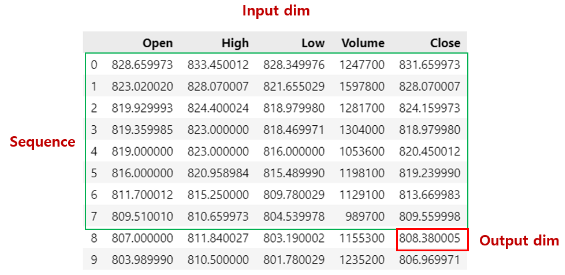

- 구글 주식 데이터로  1주 전(1~7) 데이터를 가지고 8일째 가격을 예측하는 모델
- input dim = 5, sequence =7, output dim = 1

In [3]:
df = pd.read_csv('data/data-02-stock_daily.csv')

In [4]:
df.head()

,Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
1,823.020020,828.070007,821.655029,1597800,828.070007
2,819.929993,824.400024,818.979980,1281700,824.159973
3,819.359985,823.000000,818.469971,1304000,818.979980
4,819.000000,823.000000,816.000000,1053600,820.450012


In [5]:
seq_length = 7
batch = 100

In [6]:
train_size = int(len(df)*0.7)
train_set = df[0:train_size]  
test_set = df[train_size-seq_length:]

In [7]:
train_set.shape

(512, 5)

스케일링

In [8]:
scaler_x = MinMaxScaler()
train_set.iloc[:, :-1]= scaler_x.fit_transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

scaler_y = MinMaxScaler()
train_set.iloc[:, -1]= scaler_y.fit_transform(train_set.iloc[:, [-1]])
test_set.iloc[:, -1] = scaler_y.transform(test_set.iloc[:, [-1]])

데이터셋 생성 및 tensor 형태로 변환

In [9]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim


In [10]:
def build_dataset(time_series, seq_length):
    dataX, dataY = [], []
    for i in range(len(time_series) - seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)
        
    return np.array(dataX), np.array(dataY)

In [11]:
trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

In [12]:
# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

In [13]:
trainX_tensor.shape

torch.Size([505, 7, 5])

In [14]:
# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset, 
                        batch_size=batch,
                        shuffle=True,
                        drop_last = True
                        )

모델 만들기  
- 입력 5개, 출력 1개, 히든 스테이트는 10개, 학습률은 0.01로 지점  
- reset_hidden_state로 이전 시퀀스의 영향을 받지 않도록 함

In [15]:
data_dim = 5
hidden_dim = 10 
output_dim = 1 
learning_rate = 0.01
nb_epochs = 100

In [16]:
class Net(nn.Module):
    def __init__(self, 
                 input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(
            input_size = input_dim,
            hidden_size = hidden_dim,
            num_layers = layers,
            # dropout = 0.1,
            batch_first = True
        )
        self.fc = nn.Linear(
            in_features= hidden_dim,
            out_features= output_dim,
            bias= True
        )
        
    def reset_hidden_state(self): #학습 초기화를 위한 함수
        self.hidden = (
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
        
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

학습  
- verbose는 epoch를 해당 verbose번째 마다 출력하기 위함이고, 
- patience는 train loss를 patience만큼 이전 손실값과 비교해 줄어들지 않으면 학습을 종료시킬 때 사용한다. 
- early stopping으로 epoch의 횟수는 늘어나지만 학습의 효과가 보이지 않으면 중단하는 코드를 추가하였다.

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
def train_model(model,
                train_df, 
                num_epochs = None,
                lr = None,
                verbose = 10,
                patience = 10
                ):
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    #epoch 마다 loss 저장
    train_hist = np.zeros(nb_epochs)
    
    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):
            x_train, y_train = samples
            
            # seq별 hidden state reset ??????
            model.reset_hidden_state()
            
            outputs = model(x_train)
            loss = criterion(outputs, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
            
        train_hist[epoch] = avg_cost
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

모델 학습

In [19]:
net = Net(data_dim, 
          hidden_dim, 
          seq_length, 
          output_dim, 
          1
          ).to('cpu') # GPU 안됨 수정요

In [20]:
net

Net(
  (lstm): LSTM(5, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [21]:
model, train_hist = train_model(
    net, 
    dataloader, 
    num_epochs = nb_epochs, 
    lr = learning_rate, 
    verbose = 20, 
    patience = 10
    )

Epoch: 0000 train loss : 0.6380
Epoch: 0020 train loss : 0.0102
Epoch: 0040 train loss : 0.0079
Epoch: 0060 train loss : 0.0073
Epoch: 0080 train loss : 0.0068


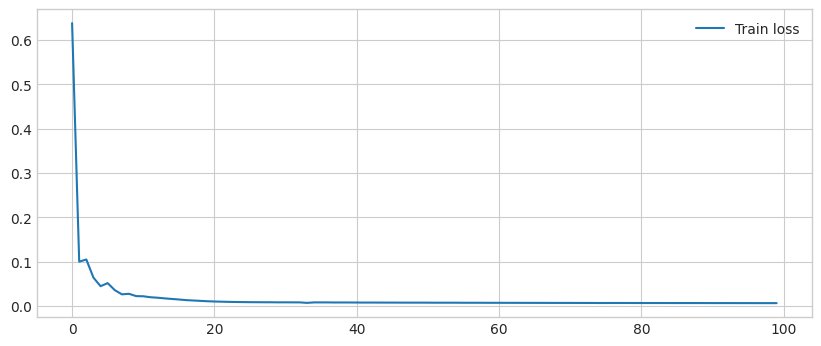

In [22]:
fig = plt.figure(figsize = (10, 4))
plt.plot(train_hist, label = 'Train loss')
plt.legend()
plt.show()

모델 저장

In [23]:
PATH = "./Timeseries_LSTM_data-02-stock_daily_.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

Net(
  (lstm): LSTM(5, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

Evaluation

-  torch.no_grad() 함수를 사용하면 gradient 계산을 수행하지 않게 되어 메모리 사용량을 아껴준다고 한다. 
- 또한 예측시에도 새로운 seq가 입력될 때마다 hidden_state를 초기화해야 이전 seq의 영향을 받지 않는다고 한다.

In [24]:
with torch.no_grad():
    model.eval()
    pred = []
    for pr in range(len(testX_tensor)):
        #model.reset_hidden_state()
        
        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)
        
    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

NotImplementedError: Could not run 'aten::mkldnn_rnn_layer' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::mkldnn_rnn_layer' is only available for these backends: [CPU, Meta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMeta, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

CPU: registered at aten/src/ATen/RegisterCPU.cpp:31034 [kernel]
Meta: registered at /dev/null:228 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:144 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:491 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:280 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:63 [backend fallback]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradHIP: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradMPS: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradIPU: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradXPU: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradHPU: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradVE: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradLazy: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradMeta: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradMTIA: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
AutogradNestedTensor: registered at ../torch/csrc/autograd/generated/VariableType_2.cpp:17472 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_2.cpp:16726 [kernel]
AutocastCPU: registered at ../aten/src/ATen/autocast_mode.cpp:492 [kernel]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:354 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:815 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1073 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:152 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:487 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:148 [backend fallback]


- 추후 확인